In [3]:
import matplotlib.pyplot as plt
fontsize = 8
fontstyle = {
    "pdf.fonttype": 42, # type 3 pdf fonts
    "mathtext.default": 'regular', # italic math
    'mathtext.fontset': 'cm',
    'font.family' : 'STIXGeneral',
    "text.latex.preamble":
        r'\usepackage{upgreek}',
    "text.usetex": True, # latex-based math
    # sans-serif Helvetica font
    #"text.latex.preamble":
    #    r'\usepackage{helvet} \usepackage{sansmath} \sansmath',
    #"font.family": "sans-serif",
    # font sizes
    "axes.labelsize": fontsize,
    'axes.titlesize': fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    'xtick.direction': "inout",
    'xtick.top': True,
    'xtick.major.size': 4,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    "ytick.labelsize": fontsize,
    'ytick.direction': "inout",
    'ytick.right': True,
    'ytick.major.size': 4,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    "axes.linewidth": 0.5,
}

plt.rcParams.update(fontstyle)

letters_lower = [r"$\mathrm{\bf{%s}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"]
letters_round = [r"$\mathrm{\bf{(%s)}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"]
letters_upper = [r"$\bf{%s}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz".upper()]
letters_map = {"round": letters_round, "upper": letters_upper, "lower":letters_lower}  
def lettering(ax, x, y, num, color="k", mode="round", **kwargs):    
    letters = letters_map[mode]    
    ax.text(x, y, letters[num], weight="bold", transform=ax.transAxes,            
            horizontalalignment="center", verticalalignment="center", color=color, **kwargs)

cmap = plt.colormaps['tab20']

In [ ]:
import analysis
import numpy as np
import matplotlib.pyplot as plt
# ("telescope", "Telescope"), 
names = [("microphone", "Sagnac"), ("sagnac", "Sagnac"), ("split beam", "SplitBeam")]
phis = ["phi" + str(int(np.append(82, np.linspace(145, 160, 16))[i])) + ".tdms" for i in range(len(np.append(82, np.linspace(145, 160, 16))))]
systems = np.array([])
for n in names:
    systems = np.append(systems, analysis.System(n[0], ["../data/20230801/" + n[1] + "/iter_0.tdms"] + ["../data/20230801/" + n[1] + "/MinDetect/" + i for i in phis], phis = [int(p[3:-5]) for p in phis]))

def Daici(freq, dist = 0.1, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    from scipy.special import kv
    a = get_sound_speed(T, 0.5, 99e3)
    c = dist / a
    s = c * freq * 2j * np.pi
    return s * kv(1, s) * np.exp(s)

def mic_correct(c, taps = 151, lfs = 0.68e-3) -> (list, list):
    """
    mic_correct uses the impulse response function of the microphone
    to correct the signal using a digital filter (scipy.signal.filtfilt).
    :param c: collection object of TDMS object.
    :param lfs: lfs of microphone (provided by manufacturer).
    :return: list of times of the collection data and 
             list of corrected signal of the collection data.
    """
    import acoustic_entrainment
    import scipy.signal as sig
    import numpy as np
    # creating array of gain values using acoustic_entrainment.dBs_orig
    gains = lfs * 10 ** (acoustic_entrainment.dBs_orig / 20)
    # making the filter using sig.firwin2
    # 1st value provided is the number of taps for the filter
    # 2nd value is the range of frequencies for the filter -- specified in acoustic_entrainment
    # 3rd value is the array of gains created above
    # 4th value is the maximum frequency times two
    # this filter is also converted into a minimum phase filter (sig.minimum_phase)
    # lastly, the filter is translated into its inverse using ifft and 1 / fft
    filter = np.real(np.fft.ifft(1 / np.fft.fft(sig.minimum_phase(sig.firwin2(taps, np.r_[0, acoustic_entrainment.fs_orig], np.r_[0, gains], fs = 2 * acoustic_entrainment.fs_orig[-1])))))
    return c.t, sig.filtfilt(filter, [1], c.x)

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
ind = 0
peak = [[], [], []]
LER_t = [[], [], []]
# fig, ax = plt.subplots(len(systems[0].get_data()[ind].collection) - 1, 1)

systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0
cutoffs = [2e5, 2e6, 2e6]
b_cutoffs = [8 * 2e5, 2 * 2e6, 2 * 2e6]
cals = [[], []]
tau = [[], []]
for i, s in enumerate(systems):
    if i == 0:
        systems[i].get_data()[ind].apply("detrend", mode = "constant", inplace = True)
        systems[i].get_data()[ind].apply("lowpass", cutoff = cutoffs[i], inplace = True)
        systems[i].get_data()[ind].apply("bin_average", Npts = int(systems[i].get_data()[ind].r / b_cutoffs[i]), inplace = True)
    for col_i in range(1, len(s.get_data()[ind].collection)):
        if i == 0:
            s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x = mic_correct(s.get_data()[ind].collection[col_i])
            # ax[col_i - 1].set_xlim([4.1e-4, 4.5e-4])
            # ax[col_i - 1].plot(s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x)
        else:
            s.set_data(ind = ind, tmin = 4.3e-4, tmax = 5e-4)
            s.get_data()[ind].apply("shift", tau = -4.3e-4, inplace = True)
            s.get_data()[ind].apply("correct", response = Daici, recollect = True)
            s.get_data()[ind].apply("detrend", mode = "constant", inplace = True)
            s.get_data()[ind].apply("lowpass", cutoff = cutoffs[i], inplace = True)
            s.get_data()[ind].apply("bin_average", Npts = int(systems[i].get_data()[ind].r / b_cutoffs[i]), inplace = True)
            tau[i - 1].append(analysis.mic_tau_shift(systems[i], systems[0], ind, col_i))
            s.get_data()[ind].apply("shift", tau = -tau[i - 1][-1], inplace = True)
            cals[i - 1].append(analysis.calc_cal_factor(s.get_data()[ind].collection[col_i], systems[0].get_data()[ind].collection[col_i], i))
            s.get_data()[ind].apply("calibrate", cal = cals[i - 1][-1], inplace = True)
            # if i != 2:
            # ax[col_i - 1].plot(s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x)
        peak[i].append(np.max(s.get_data()[ind].collection[col_i].time_gate(tmin = 4e-4, tmax = 4.5e-4)[1]))
        s_idx = np.where(s.get_data()[ind].collection[col_i].x == np.max(s.get_data()[ind].collection[col_i].time_gate(tmin = 3.5e-4, tmax = 5e-4)[1][0]))[0][0]
        f_idx = np.where(s.get_data()[ind].collection[col_i].x == peak[i][-1])[0][0]
        ten_idx = np.where(s.get_data()[ind].collection[col_i].x == find_nearest(s.get_data()[ind].collection[col_i].x[s_idx:f_idx], peak[i][-1] * 0.1))[0][0]
        ninety_idx = np.where(s.get_data()[ind].collection[col_i].x == find_nearest(s.get_data()[ind].collection[col_i].x[s_idx:f_idx], peak[i][-1] * 0.9))[0][0]
        LER_t[i].append(s.get_data()[ind].collection[col_i].t[ninety_idx] - s.get_data()[ind].collection[col_i].t[ten_idx])
# fig.set_size_inches(3.375, 288)
# plt.show()
systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0

In [ ]:
print("\033[4m" + "Sagnac Calibration Factors:" + "\033[0m")
print("Average Calibration Factor:\t\t%.2e +/- %.2e" % (np.mean(1 / np.array(cals[0])), np.std(1 / np.array(cals[0]))))
print("Error Percentage:\t\t\t%1.2f%%" % (100 * np.std(1 / np.array(cals[0])) / np.mean(1 / np.array(cals[0]))))
print(1 / np.array(cals[0]))
print("Sagnac Peak Values")
print(np.array(peak[1]))
print("Sagnac LER Times")
print("Average LER Times:\t\t%.2e +/- %.2e" % (np.mean(LER_t[1]), np.std(LER_t[1])))
print(np.array(LER_t[1]))

print("\n\n=================================================================================")
print("=================================================================================")

print("\n\n\033[4m" + "SB Calibration Factors" + "\033[0m")
print("Average Calibration Factor:\t\t%.2e +/- %.2e" % (np.mean(1 / np.array(cals[1])), np.std(1 / np.array(cals[1]))))
print("Error Percentage:\t\t\t%1.2f%%" % (100 * np.std(1 / np.array(cals[1])) / np.mean(1 / np.array(cals[1]))))
print(1 / np.array(cals[1]))
print("SB Peak Values")
print(np.array(peak[2]))
print("SB LER Times")
print("Average LER Times:\t\t%.2e +/- %.2e" % (np.mean(LER_t[2]), np.std(LER_t[2])))
print(np.array(LER_t[2]))

fig, ax = plt.subplots(3, 1)
ax[0].plot(peak[0], label = "mic peaks")
ax[1].plot(peak[1], label = "SSB peaks")
ax[2].plot(peak[2], label = "SB peaks")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title("Shot Number vs Peaks")
# fig.savefig("Peaks.png")
plt.show()

In [ ]:
ind = 0
col_i = 3

systems[0].set_data(ind = ind)
print(np.max(systems[0].get_data()[ind].collection[col_i].x))
systems[0].get_data()[ind].apply("detrend", mode = "constant", inplace = True)
systems[0].get_data()[ind].apply("lowpass", cutoff = 2e5, inplace = True)
systems[0].get_data()[ind].apply("bin_average", Npts = int(systems[0].get_data()[ind].r / (8 * 2e5)), inplace = True)
print(np.max(systems[0].get_data()[ind].collection[col_i].x))
systems[0].get_data()[ind].collection[col_i].t, systems[0].get_data()[ind].collection[col_i].x = mic_correct(systems[0].get_data()[ind].collection[col_i])
print(np.max(systems[0].get_data()[ind].collection[col_i].x))

systems[0].set_data(ind = ind)
print(np.max(systems[0].get_data()[ind].collection[col_i].x))
systems[0].get_data()[ind].apply("detrend", mode = "constant", inplace = True)
systems[0].get_data()[ind].apply("lowpass", cutoff = 2e5, inplace = True)
systems[0].get_data()[ind].apply("bin_average", Npts = int(systems[0].get_data()[ind].r / (8 * 2e5)), inplace = True)
print(np.max(systems[0].get_data()[ind].collection[col_i].x))
systems[0].get_data()[ind].collection[col_i].t, systems[0].get_data()[ind].collection[col_i].x = mic_correct(systems[0].get_data()[ind].collection[col_i])
print(np.max(systems[0].get_data()[ind].collection[col_i].x))

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

peaks = []
LERs = []
cals = []
taus = []
cutoffs = [2e5, 2e6, 2e6]
b_cutoffs = [8 * 2e5, 2 * 2e6, 2 * 2e6]
for ind in range(len(systems[0].get_data())):
    peak = [[], [], []]
    LER_t = [[], [], []]
    cal = [[], []]
    tau = [[], []]
    systems[0].set_data(ind = ind) # set mic to data ind = 0
    systems[1].set_data(ind = ind) # sagnac, data ind = 0
    systems[2].set_data(ind = ind) # split, data ind = 0
    # fig, ax = plt.subplots(len(systems[0].get_data()[ind].collection) - 1, 1)
    
    print("Data File #" + str(ind), "started...")
    for i, s in enumerate(systems):
        if i == 0:
            systems[i].get_data()[ind].apply("detrend", mode = "constant", inplace = True)
            systems[i].get_data()[ind].apply("lowpass", cutoff = cutoffs[i], inplace = True)
            systems[i].get_data()[ind].apply("bin_average", Npts = int(systems[i].get_data()[ind].r / b_cutoffs[i]), inplace = True)
        for col_i in range(1, len(s.get_data()[ind].collection)):
            if i == 0:
                s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x = mic_correct(s.get_data()[ind].collection[col_i])
                # ax[col_i - 1].set_xlim([4.1e-4, 4.5e-4])
                # ax[col_i - 1].plot(s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x)
            else:
                s.set_data(ind = ind, tmin = 4.3e-4, tmax = 5e-4)
                s.get_data()[ind].apply("shift", tau = -4.3e-4, inplace = True)
                # s.get_data()[ind].apply("correct", response = Daici, recollect = True)
                s.get_data()[ind].apply("detrend", mode = "constant", inplace = True)
                s.get_data()[ind].apply("lowpass", cutoff = cutoffs[i], inplace = True)
                s.get_data()[ind].apply("bin_average", Npts = int(systems[i].get_data()[ind].r / b_cutoffs[i]), inplace = True)
                if i == 1 or (i == 2 and ind < 5):
                    tau[i - 1].append(analysis.mic_tau_shift(systems[i], systems[0], ind, col_i))
                    s.get_data()[ind].apply("shift", tau = -tau[i - 1][-1], inplace = True)
                if i == 1:
                    cal[i - 1].append(analysis.calc_cal_factor(s.get_data()[ind].collection[col_i], systems[0].get_data()[ind].collection[col_i], 2))
                    s.get_data()[ind].apply("calibrate", cal = cal[i - 1][-1], inplace = True)
                elif i == 2 and ind < 5:
                    cal[i - 1].append(analysis.calc_cal_factor(s.get_data()[ind].collection[col_i], systems[0].get_data()[ind].collection[col_i], 4))
                    s.get_data()[ind].apply("calibrate", cal = cal[i - 1][-1], inplace = True)
                # if i != 2:
                # ax[col_i - 1].plot(s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x)
            if i == 0 or i == 1 or (i == 2 and ind < 5):
                peak[i].append(np.max(s.get_data()[ind].collection[col_i].time_gate(tmin = 4e-4, tmax = 4.5e-4)[1]))
                s_idx = np.where(s.get_data()[ind].collection[col_i].x == np.max(s.get_data()[ind].collection[col_i].time_gate(tmin = 3.5e-4, tmax = 5e-4)[1][0]))[0][0]
                f_idx = np.where(s.get_data()[ind].collection[col_i].x == peak[i][-1])[0][0]
                ten_idx = np.where(s.get_data()[ind].collection[col_i].x == find_nearest(s.get_data()[ind].collection[col_i].x[s_idx:f_idx], peak[i][-1] * 0.1))[0][0]
                ninety_idx = np.where(s.get_data()[ind].collection[col_i].x == find_nearest(s.get_data()[ind].collection[col_i].x[s_idx:f_idx], peak[i][-1] * 0.9))[0][0]
                LER_t[i].append(s.get_data()[ind].collection[col_i].t[ninety_idx] - s.get_data()[ind].collection[col_i].t[ten_idx])
        if i == 0 or i == 1 or (i == 2 and ind < 5):
            print(s.get_name(), "processed successfully!")
    # fig.set_size_inches(3.375, 200)
    # fig.savefig("allshotsadjusted.png")
    # plt.figure(layout = "constrained")
    print("Data File #" + str(ind), "finished!\n")
    # plt.show()
    peaks.append(peak)
    LERs.append(LER_t)
    cals.append(cal)
    taus.append(tau)
    systems[0].set_data(ind = ind) # set mic to data ind = 0
    systems[1].set_data(ind = ind) # sagnac, data ind = 0
    systems[2].set_data(ind = ind) # split, data ind = 0

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

ind = 11
cutoffs = [2e5, 2e6, 2e6]
b_cutoffs = [8 * 2e5, 2 * 2e6, 2 * 2e6]
peak = [[], [], []]
LER_t = [[], [], []]
cal = [[], []]
tau = [[], []]
systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0
fig, ax = plt.subplots(len(systems[0].get_data()[ind].collection) - 1, 1)
fig.set_size_inches(3.375, 200)

print("Data File #" + str(ind), "started...")
for i, s in enumerate(systems):
    if i == 0:
        systems[i].get_data()[ind].apply("detrend", mode = "constant", inplace = True)
        systems[i].get_data()[ind].apply("lowpass", cutoff = cutoffs[i], inplace = True)
        systems[i].get_data()[ind].apply("bin_average", Npts = int(systems[i].get_data()[ind].r / b_cutoffs[i]), inplace = True)
    for col_i in range(1, len(s.get_data()[ind].collection)):
        if i == 0:
            # s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x = mic_correct(s.get_data()[ind].collection[col_i])
            ax[col_i - 1].set_xlim([4.1e-4, 4.6e-4])
            ax[col_i - 1].plot(s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x)
        else:
            s.set_data(ind = ind, tmin = 4.3e-4, tmax = 5e-4)
            s.get_data()[ind].apply("shift", tau = -4.3e-4, inplace = True)
            # s.get_data()[ind].apply("correct", response = Daici, recollect = True)
            s.get_data()[ind].apply("detrend", mode = "constant", inplace = True)
            s.get_data()[ind].apply("lowpass", cutoff = cutoffs[i], inplace = True)
            s.get_data()[ind].apply("bin_average", Npts = int(systems[i].get_data()[ind].r / b_cutoffs[i]), inplace = True)
            if i != 2:
                tau[i - 1].append(analysis.mic_tau_shift(systems[i], systems[0], ind, col_i))
                s.get_data()[ind].apply("shift", tau = -tau[i - 1][-1], inplace = True)
                # cal[i - 1].append(analysis.calc_cal_factor(s.get_data()[ind].collection[col_i], systems[0].get_data()[ind].collection[col_i], 2))
                # s.get_data()[ind].apply("calibrate", cal = cal[i - 1][-1], inplace = True)
            if i != 2:
                ax[col_i - 1].plot(s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x)
        if i == 0 or i == 1 or (i == 2 and ind < 5):
            peak[i].append(np.max(s.get_data()[ind].collection[col_i].time_gate(tmin = 4e-4, tmax = 4.5e-4)[1]))
            s_idx = np.where(s.get_data()[ind].collection[col_i].x == np.max(s.get_data()[ind].collection[col_i].time_gate(tmin = 3.5e-4, tmax = 5e-4)[1][0]))[0][0]
            f_idx = np.where(s.get_data()[ind].collection[col_i].x == peak[i][-1])[0][0]
            ten_idx = np.where(s.get_data()[ind].collection[col_i].x == find_nearest(s.get_data()[ind].collection[col_i].x[s_idx:f_idx], peak[i][-1] * 0.1))[0][0]
            ninety_idx = np.where(s.get_data()[ind].collection[col_i].x == find_nearest(s.get_data()[ind].collection[col_i].x[s_idx:f_idx], peak[i][-1] * 0.9))[0][0]
            LER_t[i].append(s.get_data()[ind].collection[col_i].t[ninety_idx] - s.get_data()[ind].collection[col_i].t[ten_idx])
    if i == 0 or i == 1 or (i == 2 and ind < 5):
        print(s.get_name(), "processed successfully!")
# fig.savefig("allshotsadjusted.png")
plt.figure(layout = "constrained")
print("Data File #" + str(ind), "finished!\n")
plt.show()
systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0

In [ ]:
print("\033[4m" + "Sagnac Calibration Factors:" + "\033[0m")
print("Average Calibration Factor:\t\t%.2e +/- %.2e" % (np.mean(1 / np.array(cals[0])), np.std(1 / np.array(cals[0]))))
print("Error Percentage:\t\t\t%1.2f%%" % (100 * np.std(1 / np.array(cals[0])) / np.mean(1 / np.array(cals[0]))))
print(1 / np.array(cals[0]))
print("Sagnac Peak Values")
print(np.array(peak[1]))
print("Sagnac LER Times")
print("Average LER Times:\t\t%.2e +/- %.2e" % (np.mean(LER_t[1]), np.std(LER_t[1])))
print(np.array(LER_t[1]))

print("\n\n=================================================================================")
print("=================================================================================")

print("\n\n\033[4m" + "SB Calibration Factors" + "\033[0m")
print("Average Calibration Factor:\t\t%.2e +/- %.2e" % (np.mean(1 / np.array(cals[1])), np.std(1 / np.array(cals[1]))))
print("Error Percentage:\t\t\t%1.2f%%" % (100 * np.std(1 / np.array(cals[1])) / np.mean(1 / np.array(cals[1]))))
print(1 / np.array(cals[1]))
print("SB Peak Values")
print(np.array(peak[2]))
print("SB LER Times")
print("Average LER Times:\t\t%.2e +/- %.2e" % (np.mean(LER_t[2]), np.std(LER_t[2])))
print(np.array(LER_t[2]))

fig, ax = plt.subplots(2, 1)
ax[0].plot(peak[0], label = "mic peaks")
ax[1].plot(peak[1], label = "SSB peaks")
ax[1].plot(peak[2], label = "SB peaks")
ax[0].legend()
ax[1].legend()
ax[1].legend()
ax[0].set_title("Shot Number vs Peaks")
fig.savefig("Peaks.png")
plt.show()

NameError: name 'systems' is not defined

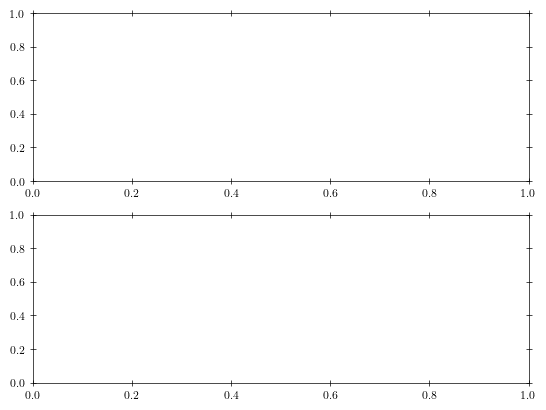

In [2]:
fig, ax = plt.subplots(2, 1)

ind = 2
col_i = 2
l_cutoff = 2e6
m_cutoff = 2e5
systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0

for i, s in enumerate(systems):
    if i == 0:
        s.get_data()[ind].apply("detrend", mode = "constant", inplace = True)
        s.get_data()[ind].apply("lowpass", cutoff = m_cutoff, inplace = True)
        s.get_data()[ind].apply("bin_average", Npts = int(systems[0].get_data()[ind].r / (8 * m_cutoff)), inplace = True)
        s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x = mic_correct(s.get_data()[ind].collection[col_i])
        ax[0].plot(s.get_data()[ind].collection[col_i].t * 1e6 - 410, s.get_data()[ind].collection[col_i].x)
    else:
        s.set_data(ind = ind, tmin = 4.3e-4, tmax = 5e-4)
        s.get_data()[ind].apply("shift", tau = -4.3e-4, inplace = True)
        # s.get_data()[ind].apply("correct", response = Daici, recollect = True)
        s.get_data()[ind].apply("detrend", mode = "constant", inplace = True)
        s.get_data()[ind].apply("lowpass", cutoff = l_cutoff, inplace = True)
        s.get_data()[ind].apply("bin_average", Npts = int(systems[i].get_data()[ind].r / (2 * l_cutoff)), inplace = True)
        tau = analysis.mic_tau_shift(systems[i], systems[0], ind, col_i)
        s.get_data()[ind].apply("shift", tau = -tau, inplace = True)
        cal = analysis.calc_cal_factor(s.get_data()[ind].collection[col_i], systems[0].get_data()[ind].collection[col_i], i)
        s.get_data()[ind].apply("calibrate", cal = cals[i - 1][col_i - 1], inplace = True)
        ax[0].plot(s.get_data()[ind].collection[col_i].t * 1e6 - 410, s.get_data()[ind].collection[col_i].x)
systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0
# concluding figure (a)

names = ["Microphone", "Sagnac + SB", "SB"]

for i, s in enumerate(systems):
    ind = 2
    laser_cutoff = 3e6
    mic_cutoff = 3e6

    s.set_data(ind = ind)
    d = s.get_data()[ind]
    d.apply("detrend", mode = "constant", inplace = True)
    if s.get_name()[:3] == "mic":
        for col in d.collection:
            col.t, col.x = analysis.mic_correct(col)
        d.apply("lowpass", cutoff = mic_cutoff, inplace = True)
        d.apply("bin_average", Npts = int(d.r / (2 * mic_cutoff)), inplace = True)
        freq_signal, psd_signal = d.average("PSD", tmin = 4.14e-4, tmax = 4.48e-4)
    else:
        # d.apply("correct", response = Daici, recollect = True)
        d.apply("lowpass", cutoff = laser_cutoff, inplace = True)
        d.apply("bin_average", Npts = int(d.r / (2 * laser_cutoff)), inplace = True)
        d.apply("calibrate", cal = np.mean(cals), inplace = True)
        freq_signal, psd_signal = d.average("PSD", tmin = 4.37e-4, tmax = 4.57e-4)
    freq_noise, psd_noise = d.average("PSD", tmin = 1e-4, tmax = 3e-4)
    ax[1].plot(freq_noise * 1e-6, psd_noise, c = cmap.colors[2 * i + 1], zorder = i)
    ax[1].plot(freq_signal * 1e-6, psd_signal, label = names[i], c = cmap.colors[2 * i], zorder = i + 3)

ax[0].set_xlim(0, 40)
ax[0].set_xlabel(r"Time ($\upmu$s)")
ax[0].set_ylabel("Signal (Pa)")
lettering(ax[0], -0.12, 1.05, 0)

ax[1].set_xlim([0, 3])
ax[1].set_xlabel("Frequency (MHz)")
ax[1].set_ylabel("Power spectral\ndensity (Pa$^2$/Hz)")
ax[1].set_yscale("log")
lettering(ax[1], -0.12, 1.05, 1)
fig.set_size_inches(3.375, 4)
fig.tight_layout(pad = 0.5)
fig.legend(loc = "lower center", frameon = False, ncol = 1, bbox_to_anchor = (0.8, 0.8), handlelength = 0.8, handletextpad = 0.4, columnspacing = 0.8)
fig.savefig("no_Daici_PSD_and_trough_matching.png", format = "png")
plt.show()
systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0

# concluding figure (b)

In [37]:
import analysis
import numpy as np
from analysis import System
import matplotlib.pyplot as plt
systems = np.array([])
systems = np.append(systems, System("mic", ["../data/20240104/ablation-ene-scan-11-13-20_phi-19_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)]))
systems = np.append(systems, System("sagnac", ["../data/20240104/ablation-ene-scan-11-13-20_phi-19_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)]))

def Daici(freq, dist = 0.033, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    from scipy.special import kv
    a = get_sound_speed(T, 0.5, 99e3)
    c = dist / a
    s = c * freq * 2j * np.pi
    return s * kv(1, s) * np.exp(s)

def mic_correct(c, taps = 151, lfs = 0.68e-3) -> (list, list):
    """
    mic_correct uses the impulse response function of the microphone
    to correct the signal using a digital filter (scipy.signal.filtfilt).
    :param c: collection object of TDMS object.
    :param lfs: lfs of microphone (provided by manufacturer).
    :return: list of times of the collection data and 
             list of corrected signal of the collection data.
    """
    import acoustic_entrainment
    import scipy.signal as sig
    import numpy as np
    # creating array of gain values using acoustic_entrainment.dBs_orig
    gains = lfs * 10 ** (acoustic_entrainment.dBs_orig / 20)
    # making the filter using sig.firwin2
    # 1st value provided is the number of taps for the filter
    # 2nd value is the range of frequencies for the filter -- specified in acoustic_entrainment
    # 3rd value is the array of gains created above
    # 4th value is the maximum frequency times two
    # this filter is also converted into a minimum phase filter (sig.minimum_phase)
    # lastly, the filter is translated into its inverse using ifft and 1 / fft
    filter = np.real(np.fft.ifft(1 / np.fft.fft(sig.minimum_phase(sig.firwin2(taps, np.r_[0, acoustic_entrainment.fs_orig], np.r_[0, gains], fs = 2 * acoustic_entrainment.fs_orig[-1])))))
    return c.t, sig.filtfilt(filter, [1], c.x)

In [45]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# peaks = []
# LERs = []
# cals = []
# taus = []
# cutoffs = [2e5, 2e6]
# b_cutoffs = [8 * 2e5, 2 * 2e6]
# for ind in range(3, len(systems[0].get_data())):
#     peak = [[], []]
#     LER_t = [[], []]
#     cal = []
#     tau = []
#     systems[0].set_data(ind = ind) # set mic to data ind = 0
#     systems[1].set_data(ind = ind) # sagnac, data ind = 0
#     fig, ax = plt.subplots(len(systems[0].get_data()[ind].collection) - 1, 1)
#     fig.set_size_inches(3.375, 20)
    
#     print("Data File #" + str(ind), "started...")
#     for i, s in enumerate(systems):
#         print(s.get_name())
#         if i == 0:
#             systems[i].get_data()[ind].apply("detrend", mode = "constant", inplace = True)
#             systems[i].get_data()[ind].apply("lowpass", cutoff = cutoffs[i], inplace = True)
#             systems[i].get_data()[ind].apply("bin_average", Npts = int(systems[i].get_data()[ind].r / b_cutoffs[i]), inplace = True)
#         for col_i in range(1, len(s.get_data()[ind].collection)):
#             if i == 0:
#                 s.set_data()
#                 s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x = mic_correct(s.get_data()[ind].collection[col_i])
#                 # ax[col_i - 1].set_xlim([2.4e-4, 2.6e-4])
#                 ax[col_i - 1].plot(s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x)
#             else:
#                 s.set_data(ind = ind)
#                 # s.get_data()[ind].apply("correct", response = Daici, recollect = True)
#                 s.get_data()[ind].apply("detrend", mode = "constant", inplace = True)
#                 s.get_data()[ind].apply("lowpass", cutoff = cutoffs[i], inplace = True)
#                 s.get_data()[ind].apply("bin_average", Npts = int(systems[i].get_data()[ind].r / b_cutoffs[i]), inplace = True)
#                 tau.append(analysis.mic_tau_shift(systems[1], systems[0], ind, col_i, 2.4e-4, 2.55e-4, 2.4e-4, 2.5e-4))
#                 s.get_data()[ind].apply("shift", tau = -tau[-1], inplace = True)
#                 # cal.append(analysis.calc_cal_factor(s.get_data()[ind].collection[col_i], systems[0].get_data()[ind].collection[col_i], 2))
#                 # s.get_data()[ind].apply("calibrate", cal = cal[-1], inplace = True)
#                 ax[col_i - 1].plot(s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x)
#             peak[i].append(np.max(s.get_data()[ind].collection[col_i].time_gate(tmin = 4e-4, tmax = 4.5e-4)[1]))
#             s_idx = np.where(s.get_data()[ind].collection[col_i].x == np.max(s.get_data()[ind].collection[col_i].time_gate(tmin = 3.5e-4, tmax = 5e-4)[1][0]))[0][0]
#             f_idx = np.where(s.get_data()[ind].collection[col_i].x == peak[i][-1])[0][0]
#             ten_idx = np.where(s.get_data()[ind].collection[col_i].x == find_nearest(s.get_data()[ind].collection[col_i].x[s_idx:f_idx], peak[i][-1] * 0.1))[0][0]
#             ninety_idx = np.where(s.get_data()[ind].collection[col_i].x == find_nearest(s.get_data()[ind].collection[col_i].x[s_idx:f_idx], peak[i][-1] * 0.9))[0][0]
#             LER_t[i].append(s.get_data()[ind].collection[col_i].t[ninety_idx] - s.get_data()[ind].collection[col_i].t[ten_idx])
#         print(s.get_name(), "processed successfully!")
#     # fig.savefig("allshotsadjusted.png")
#     # plt.figure(layout = "constrained")
#     print("Data File #" + str(ind), "finished!\n")
#     plt.show()
#     peaks.append(peak)
#     LERs.append(LER_t)
#     cals.append(cal)
#     taus.append(tau)
#     systems[0].set_data(ind = ind) # set mic to data ind = 0
#     systems[1].set_data(ind = ind) # sagnac, data ind = 0
peaks = []
LERT = []
cals = []
taus = []
cutoffs = [2e5, 1.5e5]
b_cutoffs = [32 * 2e5, 2 * 2e6]

for ind in range(3, len(systems[0].get_data())):
    peak = [[], []]
    LER_t = [[], []]
    cal = []
    tau = []
    systems[0].set_data(ind = ind, tmin = 2.35e-4, tmax = 2.7e-4)
    systems[0].get_data()[ind].apply("shift", tau = -2.35e-4, inplace = True)
    systems[0].get_data()[ind].apply("detrend", mode = "constant", inplace = True)
    systems[0].get_data()[ind].apply("lowpass", cutoff = cutoffs[0], inplace = True)
    systems[0].get_data()[ind].apply("bin_average", Npts = int(systems[0].get_data()[ind].r / b_cutoffs[0]), inplace = True)
    systems[1].set_data(ind = ind, tmin = 2.35e-4, tmax = 2.7e-4)
    systems[1].get_data()[ind].apply("shift", tau = -2.35e-4, inplace = True)
    systems[1].get_data()[ind].apply("detrend", mode = "constant", inplace = True)
    systems[1].get_data()[ind].apply("correct", response = Daici, recollect = True)
    systems[1].get_data()[ind].apply("lowpass", cutoff = cutoffs[1], inplace = True)
    systems[1].get_data()[ind].apply("bin_average", Npts = int(systems[1].get_data()[ind].r / b_cutoffs[1]), inplace = True)
    fig, ax = plt.subplots(len(systems[0].get_data()[ind].collection[2:]), 1)
    fig.suptitle("Energy " + str(systems[0].get_data()[ind].ene) + "J")
    fig.set_size_inches(3.375, 12)
    for i, (m, l) in enumerate(zip(systems[0].get_data()[ind].collection[2:], systems[1].get_data()[ind].collection[2:])):
        m.t, m.x = mic_correct(m)
        if ind > 2:
            tau.append(analysis.mic_tau_shift(systems[1], systems[0], ind, i, 2.448e-4, 2.51e-4, 2.4e-4, 2.5e-4))
            systems[1].get_data()[ind].apply("shift", tau = -tau[-1], inplace = True)
            cal.append(analysis.calc_cal_factor(l, m, 2, 2.475e-4, 2.51e-4, 2.45e-4, 2.5e-4))
            systems[1].get_data()[ind].apply("calibrate", cal = cal[-1], inplace = True)
        ax[i].set_xlim([2.4e-4, 2.6e-4])
        ax[i].set_title("Shot \#" + str(i))
        ax[i].plot(m.t, m.x)
        ax[i].plot(l.t, l.x)
        if ind > 2:
            systems[1].get_data()[ind].apply("shift", tau = tau[-1], inplace = True)
            systems[1].get_data()[ind].apply("calibrate", cal = 1 / cal[-1], inplace = True)
    fig.tight_layout()
    cals.append(cal)
    taus.append(tau)
plt.show()

[[3526.6072404562015, 6498.88990975878, 3684.1643337468104, 5423.834492238416, 2431.0485791419965, 3815.740683731068, 5862.170514877382, 1610.476622335075, 1732.733502656853], [4023.7166820218054, 3137.7617314369318, 10114.097819239963, 7535.069323498385, 7622.419067293953, 4745.962872414726, 4734.793214904603, 6682.018760465878, -10219.986017371713], [5036.995443011208, 4635.7972319428445, 4527.618719690878, 8005.302963063761, 3844.371423505608, 7417.955949650076, 4156.910858554036, 7481.425776757632, 7416.882629022082], [5021.837154822808, 6555.538185167189, 4937.010074112057, 7411.009642179186, 5113.169424828725, 4004.401556719937, 5351.0502538505025, 8277.563184068313, 6207.844653319646], [6084.581876525228, 7321.736715933005, 6134.3027428331625, 6167.824692439262, 5323.408847044757, 6759.358984072623, 5109.83451627927, 5000.624545746676, 6131.454456450345], [6465.505616620623, 6368.248645590023, 6153.491081268209, 6738.410135738759, 5116.743174781505, 5884.859141153007, 6370.20900

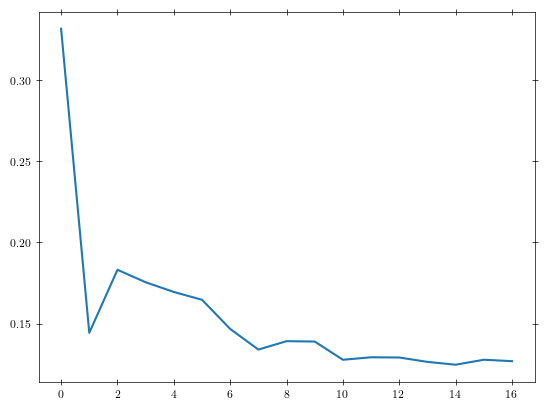

In [44]:
print(cals)
print()
vals = []
for cal in cals:
    vals.append(1e3 * np.mean(1 / np.array(cal[1:])))
    print(vals[-1])
print("\n" + str(np.mean(vals)))

fig, ax = plt.subplots()
ax.plot(vals)

In [4]:
import analysis
import numpy as np
from analysis import System
import matplotlib.pyplot as plt
systems = np.array([])
systems = np.append(systems, System("sagnac", ["../data/20240104/40KHz_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(3)]))
systems = np.append(systems, System("mic", ["../data/20240104/40KHz_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(3)]))

def Daici(freq, dist = 0.033, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    from scipy.special import kv
    a = get_sound_speed(T, 0.5, 99e3)
    c = dist / a
    s = c * freq * 2j * np.pi
    return s * kv(1, s) * np.exp(s)

def mic_correct(c, taps = 151, lfs = 0.68e-3) -> (list, list):
    """
    mic_correct uses the impulse response function of the microphone
    to correct the signal using a digital filter (scipy.signal.filtfilt).
    :param c: collection object of TDMS object.
    :param lfs: lfs of microphone (provided by manufacturer).
    :return: list of times of the collection data and 
             list of corrected signal of the collection data.
    """
    import acoustic_entrainment
    import scipy.signal as sig
    import numpy as np
    # creating array of gain values using acoustic_entrainment.dBs_orig
    gains = lfs * 10 ** (acoustic_entrainment.dBs_orig / 20)
    # making the filter using sig.firwin2
    # 1st value provided is the number of taps for the filter
    # 2nd value is the range of frequencies for the filter -- specified in acoustic_entrainment
    # 3rd value is the array of gains created above
    # 4th value is the maximum frequency times two
    # this filter is also converted into a minimum phase filter (sig.minimum_phase)
    # lastly, the filter is translated into its inverse using ifft and 1 / fft
    filter = np.real(np.fft.ifft(1 / np.fft.fft(sig.minimum_phase(sig.firwin2(taps, np.r_[0, acoustic_entrainment.fs_orig], np.r_[0, gains], fs = 2 * acoustic_entrainment.fs_orig[-1])))))
    return c.t, sig.filtfilt(filter, [1], c.x)

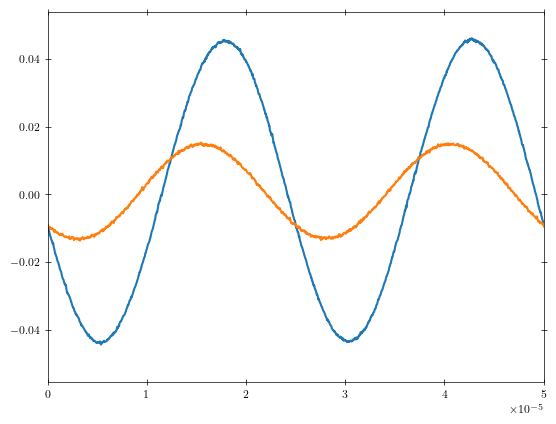

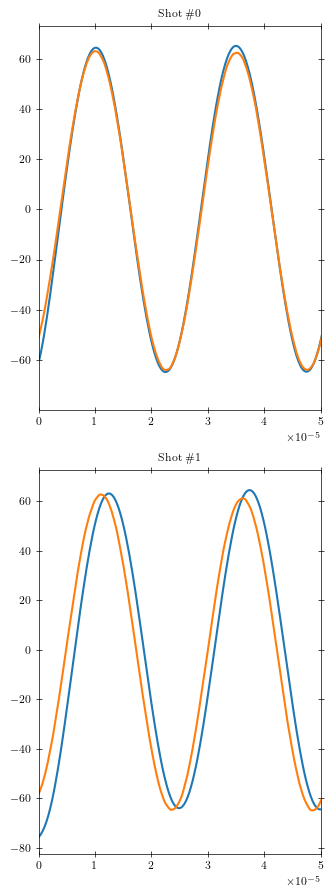

In [43]:
fig, ax = plt.subplots()
systems[0].set_data(ind = 0)
systems[1].set_data(ind = 0)

ax.set_xlim([0, 0.5e-4])
ax.plot(systems[0].get_data()[0].collection[0].t, systems[0].get_data()[0].collection[0].x)
ax.plot(systems[1].get_data()[0].collection[0].t, systems[1].get_data()[0].collection[0].x)
plt.show()

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

cutoffs = [2e5, 2e6]
b_cutoffs = [16 * 2e5, 2 * 2e6]
ind = 1
cal = []
tau = []
systems[0].set_data(ind = ind, tmin = 0, tmax = 2e-4)
systems[0].get_data()[ind].apply("detrend", mode = "constant", inplace = True)
systems[0].get_data()[ind].apply("lowpass", cutoff = cutoffs[0], inplace = True)
systems[0].get_data()[ind].apply("bin_average", Npts = int(systems[0].get_data()[ind].r / b_cutoffs[0]), inplace = True)
systems[1].set_data(ind = ind, tmin = 0, tmax = 2e-4)
systems[1].get_data()[ind].apply("detrend", mode = "constant", inplace = True)
systems[1].get_data()[ind].apply("lowpass", cutoff = cutoffs[1], inplace = True)
systems[1].get_data()[ind].apply("bin_average", Npts = int(systems[1].get_data()[ind].r / b_cutoffs[1]), inplace = True)
systems[1].get_data()[ind].apply("correct", response = Daici, recollect = True)
fig, ax = plt.subplots(len(systems[0].get_data()[ind].collection), 1)
fig.set_size_inches(3.375, 9)
for i, (m, l) in enumerate(zip(systems[0].get_data()[ind].collection, systems[1].get_data()[ind].collection)):
    m.t, m.x = mic_correct(m)
    systems[1].get_data()[ind].apply("shift", tau = 0.68e-6, inplace = True)
    systems[1].get_data()[ind].apply("calibrate", cal = 28000, inplace = True)
    ax[i].set_xlim([0, 5e-5])
    ax[i].set_title("Shot \#" + str(i))
    ax[i].plot(m.t, m.x)
    ax[i].plot(l.t, l.x)
    systems[1].get_data()[ind].apply("shift", tau = 0.68e-6, inplace = True)
    systems[1].get_data()[ind].apply("calibrate", cal = 1 / 28000, inplace = True)
fig.tight_layout()
plt.show()

0.03571428571428571


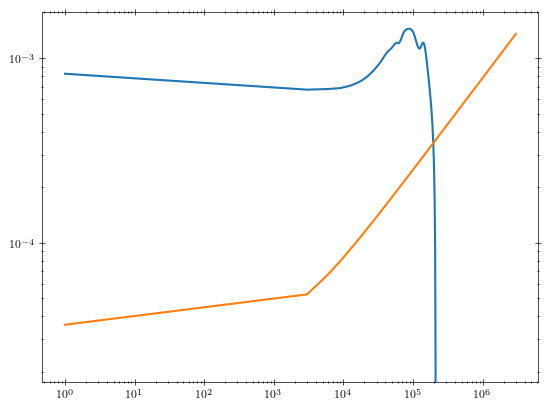

In [44]:
# print(cals)
# print(1e3 / cals[0][1])
print(1e3 / 28000)
from acoustic_entrainment import mic_response

freq = np.linspace(1, 3e6, 1000)

fig, ax = plt.subplots()

ax.loglog(freq, mic_response(freq))
ax.loglog(freq, 0.000036 * Daici(freq))